In [1]:
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout,BatchNormalization
from keras.layers import Input, concatenate
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
from keras.optimizers import SGD, Adam
from keras.applications.vgg16 import VGG16
from keras.models import Model,load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model,np_utils
from keras import regularizers
import keras.metrics as metric
from keras import backend as K
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import os
import pickle
import numpy as np
from PIL import Image as PImage
import gc

Using TensorFlow backend.


In [2]:
'''
Define a function to input all images from all subfolder in given path
Ex. Path: img    subpaths:['goku', 'luffy'...]
Input values: img path, imgsize(as a list), such as [224,224]
return 2 lists

'''
def impt_img(path, img_size):
    images = []
    labels = []
    for subpaths in os.listdir(path):
        for i in os.listdir(path + '/' + subpaths):
            img = cv2.imread(os.path.join(path, subpaths, i))
            img1 = cv2.resize(img, (img_size[0], img_size[1]))
            img2 = np.array(img1)
            images.append(img2)
            #define labels
            lbl = subpaths
            labels.append(lbl)
    return images,labels

In [3]:
img, labels = impt_img(r'img', [224, 224])

In [4]:
labels[2]

'goku'

In [5]:
'''
Convert lists to np.array for NN
'''
img = np.array(img)
labels = np.array(labels)
img.shape

(4413, 224, 224, 3)

In [6]:
'''
Use One Hot Encoder to convert string labels to matrices
'''
ohe = LabelBinarizer()
labels1 = ohe.fit_transform(labels)
labels1[1]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [7]:
'''
Split train and test sets
'''
X_train, X_test, y_train, y_test = train_test_split(img, labels1, test_size=0.2, random_state=42)
y_train.shape

(3530, 11)

In [8]:
# '''
# Initiate VGG net using built-in structure
# input_shape is (224,224,3), RGB are kept
# Output nodes number: 11, change to other numbers if the number of classes is different
# '''
# ishape=224
# model_vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (ishape, ishape, 3)) 

# for layer in model_vgg.layers:
#         layer.trainable = False
# model = Flatten()(model_vgg.output) 
# model = Dense(4096, activation='relu', name='fc1')(model)
# model = Dense(4096, activation='relu', name='fc2')(model)
# model = Dropout(0.5)(model)

# #Here, 11 can be changed
# model = Dense(11, activation = 'softmax', name='prediction')(model) 
# model_vgg_mnist_pretrain = Model(model_vgg.input, model, name = 'vgg16_pretrain')
# print(model_vgg_mnist_pretrain.summary())

In [9]:
# sgd = SGD(lr = 0.05, decay = 1e-5) 
# model_vgg_mnist_pretrain.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

# his = model_vgg_mnist_pretrain.fit(X_train, y_train, epochs = 10, batch_size = 64)
# model_vgg_mnist_pretrain.save("tester.model")

# with open("lb.pcikle", 'wb') as f:
#     f.write(pickle.dumps(ohe))

# plt.plot(his.history['acc'], 'r', his.history['loss'], 'b')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.show()

In [ ]:
'''
VGG model constructed by Karan Jaisingh
https://github.com/kjaisingh/pokemon-classifier/blob/master/pyimagesearch/smallervggnet.py
'''

In [10]:
class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        model.add(Conv2D(32, (3, 3), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))
        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same",
          input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same",
           input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, (3, 3), padding="same",
           input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same",
           input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
 
       # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
 
       # return the constructed network architecture
        return model

In [11]:
EPOCHS = 50
INIT_LR = 1e-3
BS =32
IMAGE_DIMS = (224, 224, 3)
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.3,\
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,\
                         horizontal_flip=True, fill_mode='nearest')

In [12]:
# initialize the model
print("[INFO] compiling model...")
model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
    depth=IMAGE_DIMS[2], classes=len(ohe.classes_))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
model.load_weights('tester.model') 
# train the network
print("[INFO] training network...")
H = model.fit_generator(
    aug.flow(X_train, y_train, batch_size=BS),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // BS,
    epochs=EPOCHS, verbose=1)

model.save('tester2.model')

[INFO] compiling model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[INFO] training network...
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
110/110 [==============================] - 854s 8s/step - loss: 1.2585 - acc: 0.5852 - val_loss: 1.6458 - val_acc: 0.5289
Epoch 2/50
110/110 [==============================] - 810s 7s/step - loss: 1.1253 - acc: 0.6099 - val_loss: 1.9229 - val_acc: 0.4915
Epoch 3/50
110/110 [==============================] - 791s 7s/step - loss: 1.1253 - acc: 0.6276 - val_loss: 1.5550 - val_acc: 0.5629
Epoch 4/50
110/110 [==============================] - 780s 7s/step - loss: 1.0676 - acc: 0.6468 - val_loss: 2.7085 - val_acc: 0.4417
Epoch 5/50
110/110 [==============================] - 689s 6s/step - loss: 1.0579 - acc: 0.6487 - val_loss: 1.3594 - val_acc: 0.5719
Epoch 6/50
110/110 [===========================

In [13]:
score = model.evaluate(X_test, y_test,batch_size=2)
score

883/883 [==============================] - 36s 41ms/step


[0.9794656459306547, 0.7157417893544734]

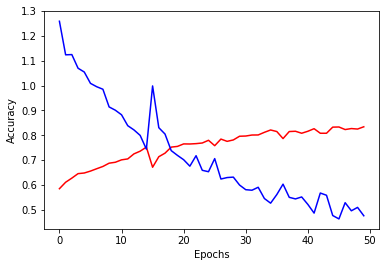

In [14]:


plt.plot(H.history['acc'], 'r', H.history['loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

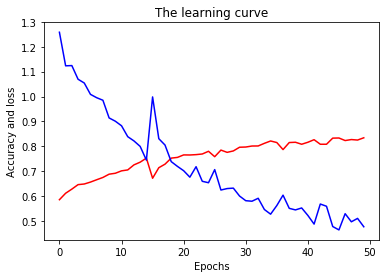

In [16]:
plt.plot(H.history['acc'], 'r', H.history['loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy and loss')
plt.title('The learning curve')
plt.show()